In [1]:
!pip -q install pymc arviz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

np.random.seed(42)


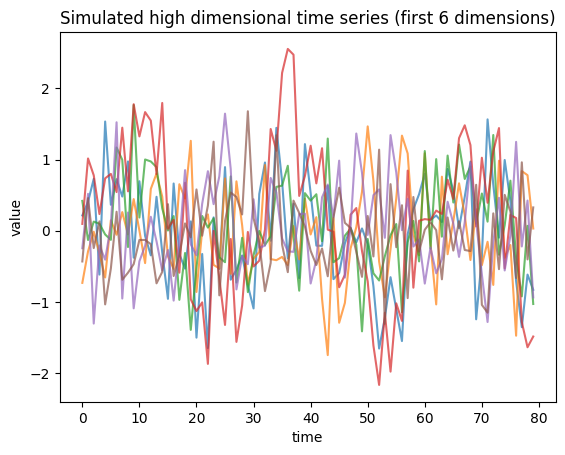

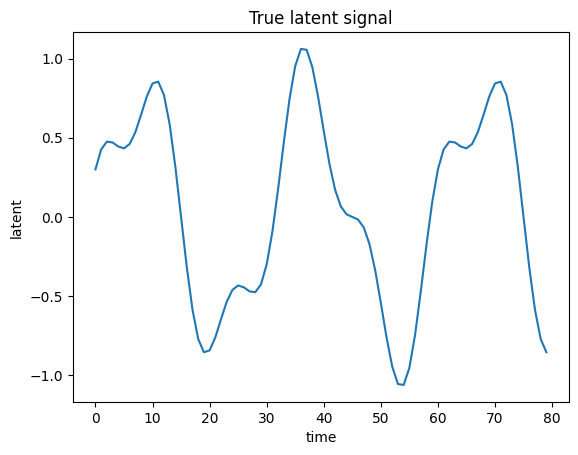

In [2]:
T = 80
D = 25
t = np.arange(T)

latent_true = 0.8 * np.sin(2 * np.pi * t / 30) + 0.3 * np.cos(2 * np.pi * t / 12)
w = np.random.normal(0, 1.0, size=D)
sigma = 0.6

Y = latent_true[:, None] * w[None, :] + np.random.normal(0, sigma, size=(T, D))

plt.figure()
for j in range(min(6, D)):
    plt.plot(t, Y[:, j], alpha=0.7)
plt.title("Simulated high dimensional time series (first 6 dimensions)")
plt.xlabel("time")
plt.ylabel("value")
plt.show()

plt.figure()
plt.plot(t, latent_true)
plt.title("True latent signal")
plt.xlabel("time")
plt.ylabel("latent")
plt.show()


/usr/local/lib/python3.12/dist-packages/pymc/distributions/timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


Output()

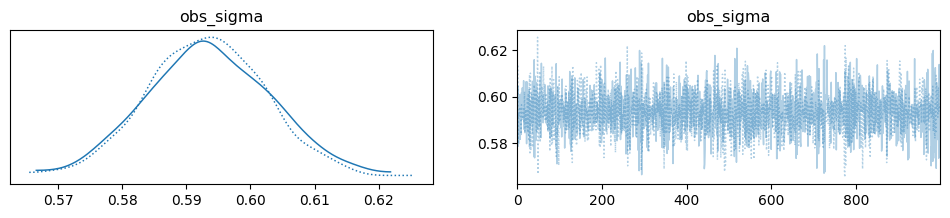

/tmp/ipython-input-3039571804.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  latent_hdi = az.hdi(latent_post.T, hdi_prob=0.94)


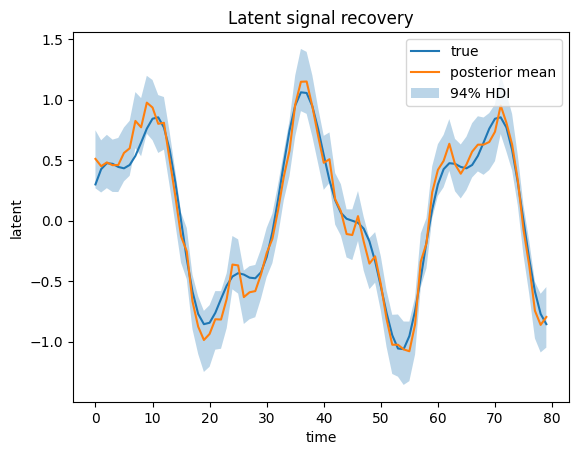

In [3]:
with pm.Model() as model:
    latent = pm.GaussianRandomWalk("latent", sigma=0.25, shape=T)
    loading = pm.Normal("loading", mu=0.0, sigma=1.0, shape=D)
    obs_sigma = pm.HalfNormal("obs_sigma", sigma=1.0)

    mu = pm.Deterministic("mu", latent[:, None] * loading[None, :])
    y_obs = pm.Normal("y_obs", mu=mu, sigma=obs_sigma, observed=Y)

    idata = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, progressbar=True)

az.plot_trace(idata, var_names=["obs_sigma"])
plt.show()

latent_post = idata.posterior["latent"].stack(sample=("chain", "draw")).values
latent_mean = latent_post.mean(axis=1)
latent_hdi = az.hdi(latent_post.T, hdi_prob=0.94)

plt.figure()
plt.plot(t, latent_true, label="true")
plt.plot(t, latent_mean, label="posterior mean")
plt.fill_between(t, latent_hdi[:, 0], latent_hdi[:, 1], alpha=0.3, label="94% HDI")
plt.title("Latent signal recovery")
plt.xlabel("time")
plt.ylabel("latent")
plt.legend()
plt.show()
